In [171]:
import os
import pickle

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import regularizers

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage

import sklearn.metrics as skmetrics

import matplotlib.pyplot as plt
%matplotlib inline

# Small Network From Scratch

TODO:


## Load training and validation images

In [26]:
train_dir = "data/posters_split/train/"
validation_dir = "data/posters_split/validation/"

In [27]:
train_filenames = os.listdir(train_dir)
n_train = len(train_filenames)

validation_filenames = os.listdir(validation_dir)
n_validation = len(validation_filenames)

In [46]:
# Load train images in arrays
images=[None]*n_train
X=[None]*n_train

for i, train_filename in enumerate(train_filenames):
    images[i] = kimage.load_img(train_dir + train_filename, target_size=(224, 224))
    X[i] = kimage.img_to_array(images[i])
    X[i] = np.expand_dims(X[i], axis=0)
    X[i] = preprocess_input(X[i]).reshape(224,224,3)  

In [47]:
# Load validation images in arrays
val_images=[None]*n_validation
val_X=[None]*n_validation

for i, validation_filename in enumerate(validation_filenames):
    val_images[i] = kimage.load_img(validation_dir + validation_filename, target_size=(224, 224))
    val_X[i] = kimage.img_to_array(val_images[i])
    val_X[i] = np.expand_dims(val_X[i], axis=0)
    val_X[i] = preprocess_input(val_X[i]).reshape(224,224,3)  

## Create first convolutional layer

In [30]:
#Single layer CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
Total params: 896.0
Trainable params: 896.0
Non-trainable params: 0.0
_________________________________________________________________


In [32]:
X_1 = np.array(X)
val_X_1 = np.array(val_X)
train_features = model.predict(X_1)
val_features = model.predict(val_X_1)

## Get genres for each of the movies from their filenames

In [33]:
genre_dict = pickle.load(open("data/genre_dict.pickle", 'rb'))

# Get movie information (including genre labels) for train and validation data from filenames
train_movie_names = os.listdir("data/posters_split/train/")
# Unique id for each movie
train_ids = [filename.split("-")[-1].split("_")[0] for filename in train_movie_names]
train_ids = [int(id) for id in train_ids]
# List of genre ids for each movie
train_genre_ids = [map(int, os.path.splitext(filename)[0].split("-")[-1].split("_")[1:]) for filename in train_movie_names]

val_movie_names = os.listdir("data/posters_split/validation/")
# Unique id for each movie
val_ids = [filename.split("-")[-1].split("_")[0] for filename in val_movie_names]
val_ids = [int(id) for id in val_ids]
# List of genre ids for each movie
val_genre_ids = [map(int, os.path.splitext(filename)[0].split("-")[-1].split("_")[1:]) for filename in val_movie_names]

## Create binary encoded response vectors for train and validation datasets

In [34]:
train_multilabels = pd.DataFrame(index=train_ids)

# multilabel binary encoding by genre
for genre_id, genre in genre_dict.items():
    train_multilabels[genre] = [int(int(genre_id) in genre_list) for genre_list in train_genre_ids]
    
val_multilabels = pd.DataFrame(index=val_ids)

# multilabel binary encoding by genre
for genre_id, genre in genre_dict.items():
    val_multilabels[genre] = [int(int(genre_id) in genre_list) for genre_list in val_genre_ids]

## Add a fully connected layer on top and train on features from first layer

In [35]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_multilabels.shape[1], activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [36]:
type(train_multilabels)

pandas.core.frame.DataFrame

In [43]:
history = model.fit(train_features, train_multilabels.values,
          epochs=10,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0)
model.save_weights('bottleneck_fc_model.h5')

In [44]:
score_scr = model.evaluate(train_features, train_multilabels.values, verbose = 0)
print("Train loss: ", score_scr[0])
print('Train accuracy:', score_scr[1])

score_scr = model.evaluate(val_features, val_multilabels.values, verbose=0)
print('Validation loss:', score_scr[0])
print('Validation accuracy:', score_scr[1])

('Train loss: ', 4.1524270704033528)
('Train accuracy:', 0.74058079714411207)
('Validation loss:', 4.1605181167865624)
('Validation accuracy:', 0.7400634412107796)


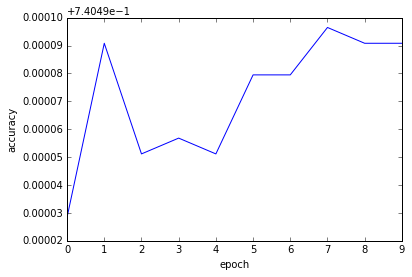

In [45]:
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

## More intense from scratch

In [173]:
#Single layer CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [174]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
activation_116 (Activation)  (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_117 (Activation)  (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 52, 52, 32)        9248      
__________

In [175]:
X_2 = np.array(X)
val_X_2 = np.array(val_X)
train_features = model.predict(X_2)
val_features = model.predict(val_X_2)

In [176]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256, activation='relu', 
                kernel_regularizer = regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.6))
model.add(Dense(train_multilabels.shape[1], activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

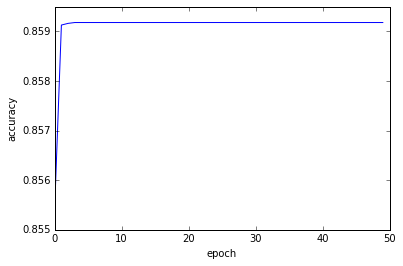

In [177]:
history = model.fit(train_features, train_multilabels.values,
          epochs=50,
          batch_size=16,
          validation_data=(val_features, val_multilabels.values),
          verbose=0)
model.save_weights('conv_6_model.h5')

plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [178]:
out = model.predict_proba(val_features)
out = np.array(out)

y_test = val_multilabels.values

y_pred = np.array([[1 if out[i,j]>=0.5 else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

print '\n '
print 'Scratch CNN Predictions'
print 'hamming loss:', skmetrics.hamming_loss(y_test, y_pred)
print 'jaccard similarity:', skmetrics.jaccard_similarity_score(y_test, y_pred)
print 'zero one loss:', skmetrics.zero_one_loss(y_test, y_pred)
print 'exact match ratio:', skmetrics.accuracy_score(y_test, y_pred)

  32/1160 [..............................] - ETA: 10s
 
Scratch CNN Predictions
hamming loss: 0.138520871143
jaccard similarity: 0.0
zero one loss: 1.0
exact match ratio: 0.0
